# Exploring the Latent Space of the Models

Here we explore the latent space of the trained models. We will use the trained models to generate new samples and visualize the latent space of the models. We will also use the latent space to interpolate between two samples and visualize the interpolation.

But first, we start by finding the most distant (in latent space) samples in the dataset (train and test) and visualize them.


In [1]:
import gc
import logging
from time import time

import logging_utils

from ModelProxy import CollaGANModelProxy, Pix2PixModelProxy, StarGANModelProxy

logging_utils.configure()

model_loaders = {
    'Pix2Pix': lambda: Pix2PixModelProxy('models/pix2pix'),
    'StarGAN': lambda: StarGANModelProxy('models/stargan'),
    'CollaGAN': lambda: CollaGANModelProxy('models/collagan'),
}


In [2]:
from dataset_utils import DatasetLoader

dataset_loader = DatasetLoader("tiny-hero", "test", limit=None)


## Finds the Distance Between Two Samples in the Latent Space


In [5]:
from scipy.spatial import distance
import numpy as np

def calculate_codes(model, dataset_loader, batch_size=128):
    codes = []
    for samples in dataset_loader.dataset.batch(batch_size):
        z = model.encode(2, 3, samples)
        codes.append(z)

    codes = np.concatenate(codes, axis=0)
    codes = np.reshape(codes, (dataset_loader.dataset_size, -1))
    return codes

def find_most_distant_codes(codes):
    distances = distance.cdist(codes, codes, "sqeuclidean")
    maxarg = np.unravel_index(distances.argmax(), distances.shape)

    return maxarg, distances



model = model_loaders["StarGAN"]()
samples = []
for dataset_name in [
    # "tiny-hero",
    "rpg-maker-2000",
    "rpg-maker-xp",
    "rpg-maker-vxace"
]:
    print(f"Processing ds {dataset_name}...")
    dataset = DatasetLoader(dataset_name, "train", limit=None)
    codes = calculate_codes(model, dataset)
    maxarg, distances = find_most_distant_codes(codes)
    samples = samples + [dataset.load_paired_images(maxarg[0]), dataset.load_paired_images(maxarg[1])]
    print("len(samples)", len(samples))
    del codes


D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


Processing ds rpg-maker-2000...
len(samples) 2
Processing ds rpg-maker-xp...
len(samples) 4
Processing ds rpg-maker-vxace...
len(samples) 6


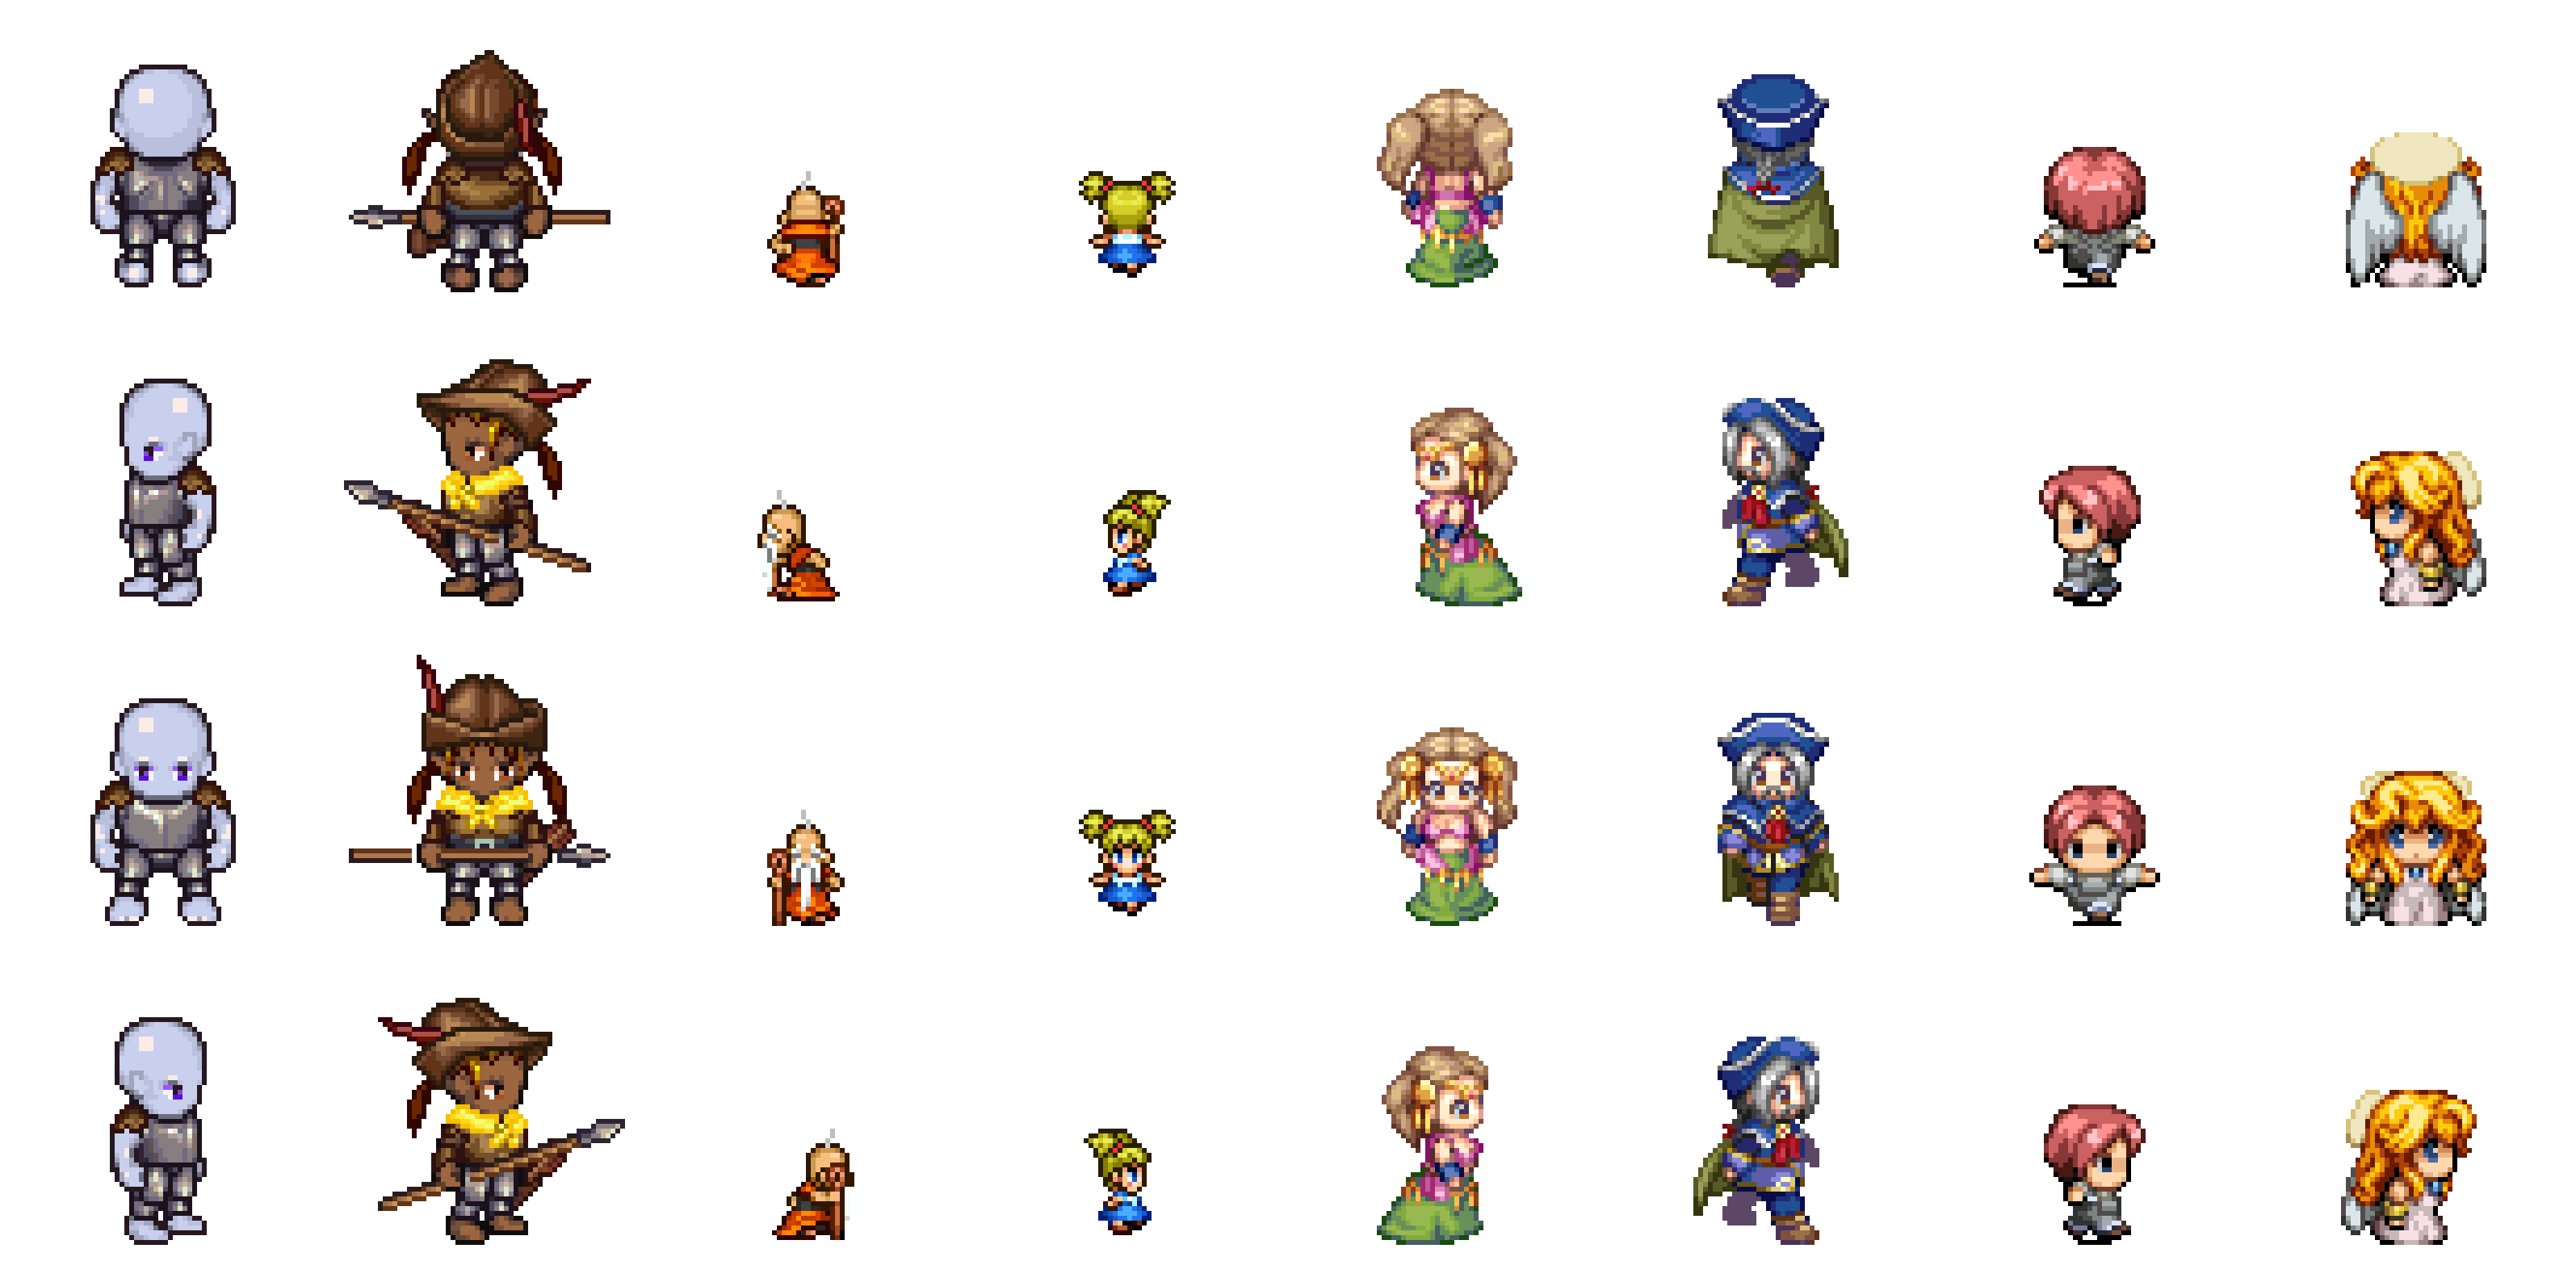

<Figure size 640x480 with 0 Axes>

In [4]:
from matplotlib import pyplot as plt


# shows an image with the four different directions in the rows and the train and test images in the columns
rows = 4
cols = len(samples)
fig = plt.figure(figsize=(4*cols, 4*rows))
for i in range(rows):
    for j in range(cols):
        plt.subplot(rows, cols, i*cols + j + 1, facecolor='w')
        plt.imshow(samples[j][i] * 0.5 + 0.5, interpolation="nearest")
        plt.axis("off")
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()
plt.savefig("output/most-distant-samples-per-dataset.png", transparent=True)